In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For percentage formatting
from matplotlib.gridspec import GridSpec
import seaborn as sns # For despine

In [90]:
import plot_style
import importlib
importlib.reload(plot_style) # Reload to ensure latest changes
plot_style.activate_plot_style()


Custom plot style 'publication_quality_plots' applied.


In [82]:
df = pd.read_parquet("../data/movies.parquet")

FOCUS_GENRES = plot_style.MOVIE_GENRES

In [88]:
# Clean and explode genres
df_clean = df[['title', 'release_year', 'genre']].dropna()
df_clean['genre'] = df_clean['genre'].astype(str).str.split(',') # Ensure it's string before split
df_exploded = df_clean.explode('genre')
df_exploded['genre'] = df_exploded['genre'].str.strip() # Clean whitespace

# Filter by FOCUS_GENRES *after* exploding
df_exploded = df_exploded[df_exploded['genre'].isin(FOCUS_GENRES)]

# Filter years
df_exploded = df_exploded[df_exploded['release_year'].between(1960, 2023)] # Adjusted range for better viz

# Total movies per year (for the bar chart) - considering only movies with at least one FOCUS_GENRE
# This needs to be calculated based on unique titles per year if a movie can have multiple FOCUS_GENRES
# and you want to count the movie once. If you want to count each genre instance, .size() is fine.
# For "number of movies produced", unique titles is better.
total_movies_per_year = df_exploded.groupby('release_year')['title'].nunique()

# Genre distribution for FOCUS_GENRES
genre_counts = df_exploded.groupby(['release_year', 'genre']).size().unstack(fill_value=0)

# Ensure all FOCUS_GENRES are present as columns, even if count is 0 for some years
# And maintain the order from FOCUS_GENRES for consistent color mapping
genre_counts = genre_counts.reindex(columns=FOCUS_GENRES, fill_value=0)

# Calculate percentage distribution *among the FOCUS_GENRES*
genre_sum_per_year = genre_counts.sum(axis=1)
genre_percent = genre_counts.div(genre_sum_per_year, axis=0).fillna(0)


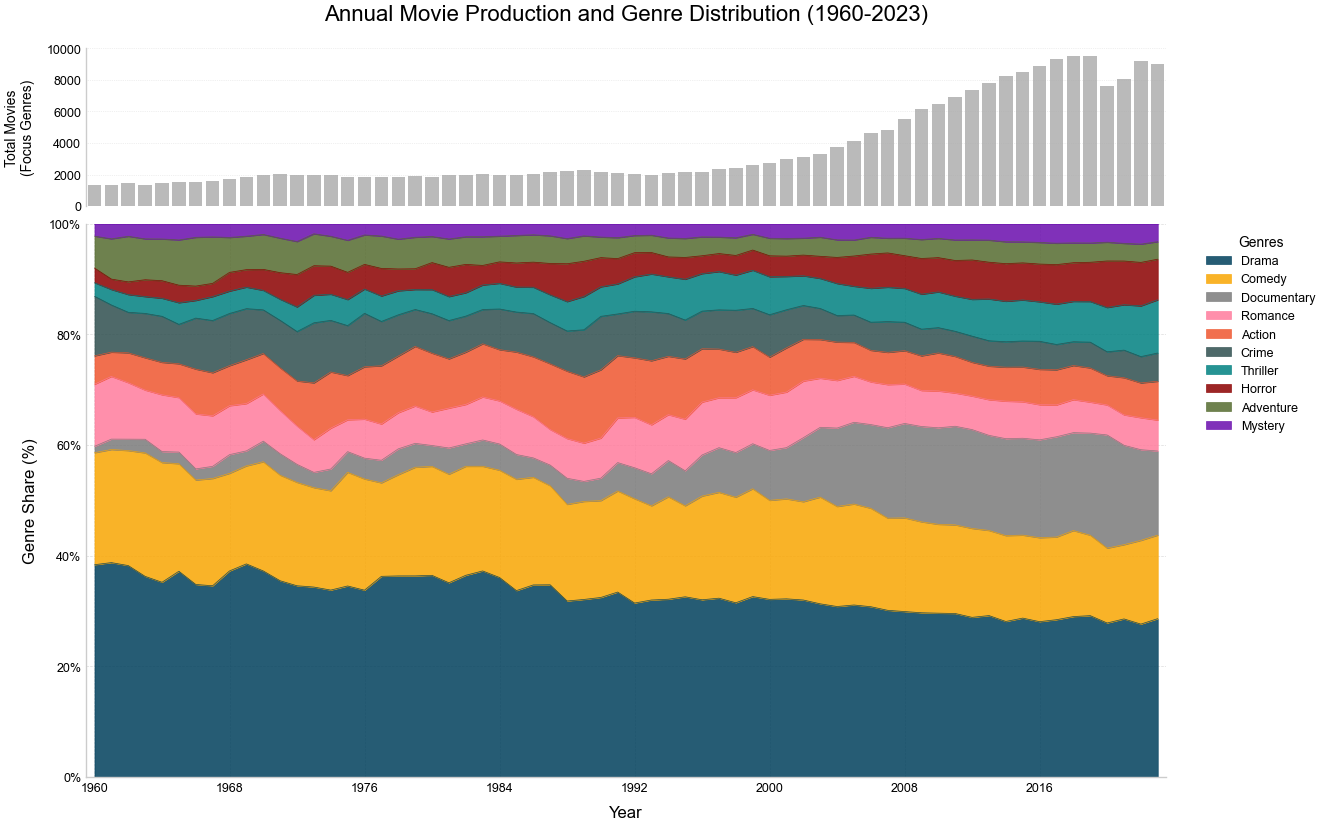

In [89]:
# ---- Plotting ----
fig = plt.figure(figsize=(15, 9)) # Slightly adjusted figsize
# gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1) # Adjusted ratios and hspace
# For even tighter integration of bar and area, we can use sharex trick more effectively
# by plotting bar on a secondary y-axis of the area plot, or careful alignment.
# Let's stick to GridSpec but refine.

# Create a GridSpec layout with more control for legend
gs = GridSpec(2, 2, height_ratios=[1, 3.5], width_ratios=[1, 0.05], hspace=0.05, wspace=0.05)
# Main plots on the left, legend on the right (in the second column of GridSpec)

ax0 = fig.add_subplot(gs[0, 0]) # Bar chart
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0) # Stacked area, shares x-axis with ax0
ax_legend = fig.add_subplot(gs[1, 1]) # Dedicated space for legend

# --- Top subplot: Total movie counts (bar chart) ---
bar_color = 'darkgray' # From your plot_style or a neutral one
ax0.bar(total_movies_per_year.index, total_movies_per_year.values,
        color=bar_color, alpha=0.8, width=0.8) # Slightly thinner bars
ax0.set_ylabel("Total Movies\n(Focus Genres)", fontsize=10) # Adjusted label
ax0.tick_params(axis='x', labelbottom=False, length=0) # Hide x-tick labels and ticks
ax0.set_title("Annual Movie Production and Genre Distribution (1960-2023)", fontsize=16, pad=20)
sns.despine(ax=ax0, bottom=True) # Remove top, right, and bottom spines
ax0.grid(False) # Turn off grid for the bar chart for cleaner look if desired
ax0.grid(True, axis='y', linestyle=':', alpha=0.6) # Keep y-axis grid subtle

# --- Bottom subplot: Stacked percent area chart ---
# Get colors from your plot_style.GENRE_COLOR_MAP
# Ensure the order of colors matches the order of columns in genre_percent
plot_colors = [plot_style.GENRE_COLOR_MAP.get(genre, '#CCCCCC') for genre in genre_percent.columns]

genre_percent.plot.area(ax=ax1, linewidth=0.5, color=plot_colors, alpha=0.85) # Added slight alpha

ax1.set_ylabel("Genre Share (%)", fontsize=12)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylim(0, 1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) # Format y-axis as percentage

# Legend handling - place it in the dedicated ax_legend
handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove() # Remove default legend from ax1
ax_legend.legend(handles, labels, loc='upper left', frameon=False, title='Genres', fontsize=9, title_fontsize=10)
ax_legend.axis('off') # Turn off axis for the legend subplot

sns.despine(ax=ax1) # Remove top and right spines for the area chart

# Set x-axis limits explicitly based on data range for better control
min_year, max_year = total_movies_per_year.index.min(), total_movies_per_year.index.max()
ax1.set_xlim(min_year - 0.5, max_year + 0.5) # Add a bit of padding

# Improve x-tick frequency if too crowded
if (max_year - min_year) > 20:
    ax1.xaxis.set_major_locator(plt.MaxNLocator(nbins=10, integer=True)) # Show around 10 ticks
plt.xticks(rotation=45, ha='right')


# Overall adjustments
# fig.tight_layout(rect=[0, 0, 0.9, 0.96]) # rect to make space for suptitle and outer legend
# Using GridSpec with a column for legend often works better than fig.tight_layout for external legends.
plt.subplots_adjust(top=0.92) # Adjust top for suptitle

plt.show()